In [25]:
# A notebook to calculate Fisher information of Gibbs state
# P_n = 1/Z exp(-beta H_n)

In [117]:
import numpy as np
import matplotlib.pyplot as plt
import scipy as sp
import scipy.constants as const
from scipy.integrate import quad

# Define constants
h = const.h
kB = const.Boltzmann

plt.rcParams['axes.titlesize'] = 24  # Set the fontsize used for Axes titles
plt.rcParams['axes.labelsize'] = 24  # Set the fontsize for x and y labels
plt.rcParams['xtick.labelsize'] = 20 # Set the fontsize of the tick labels on x-axis
plt.rcParams['ytick.labelsize'] = 20 # Set the fontsize of the tick labels on y-axis
plt.rcParams['legend.fontsize'] = 20 # Set the fontsize used in legends


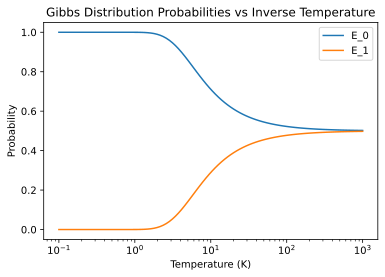

In [94]:
import numpy as np
import matplotlib.pyplot as plt

import numpy as np

def gibbs_distribution_matrix(E_list, beta_range, n_stop):
    # Truncate E_list to only include up to n_stop energy levels
    truncated_E_list = np.array(E_list[:n_stop])
    
    # Compute the outer product of negative beta_range and truncated_E_list.
    # This creates a matrix where each column corresponds to a beta value,
    # and each row corresponds to an energy level.
    boltzmann_matrix = np.exp(-np.outer(truncated_E_list, beta_range))
    
    # Sum along rows (axis 0) to get partition function values for each beta (column-wise sum).
    Z_values = np.sum(boltzmann_matrix, axis=0)
    
    # Normalize by partition function values (broadcasting division across each column).
    gibbs_matrix = boltzmann_matrix / Z_values
    
    return gibbs_matrix.T  # Transpose so that rows are betas and columns are energy levels.

# Example usage:
E_list = [1.0, 10.0]  # Replace with your actual discrete spectrum of energies.
beta_range = np.logspace(-3, 1.0, num=100)  # Inverse temperature range (replace with desired range).
n_stop = len(E_list)  # Summing over all provided energy levels.

gibbs_mat = gibbs_distribution_matrix(E_list=E_list,
                                      beta_range=beta_range,
                                      n_stop=n_stop)

# 'gibbs_mat' is now a matrix where rows correspond to different values of beta,
# and columns correspond to probabilities associated with different energy levels.

plt.figure()
for idx in range(n_stop):
    plt.semilogx(1/beta_range, gibbs_mat[:,idx], label='E_{}'.format(idx))

plt.xlabel('Temperature (K)')
plt.ylabel('Probability')
plt.title('Gibbs Distribution Probabilities vs Inverse Temperature')
plt.legend()
plt.show()


Now that we have code to figure out $P(x|\beta)$, we can try implementing the Fisher Information calculation numerically. 

From Gavin Crooks' note on [Fisher Information and Statistical Mechanics](https://threeplusone.com/pubs/on_fisher_info.pdf) we can go ahead and write the Fisher information as 


$$ I(x) = \sum_{x} p(x|\beta) \left(\frac{\partial \text{  ln  }p(x|\beta)}{\partial \beta}\right)^{2} $$



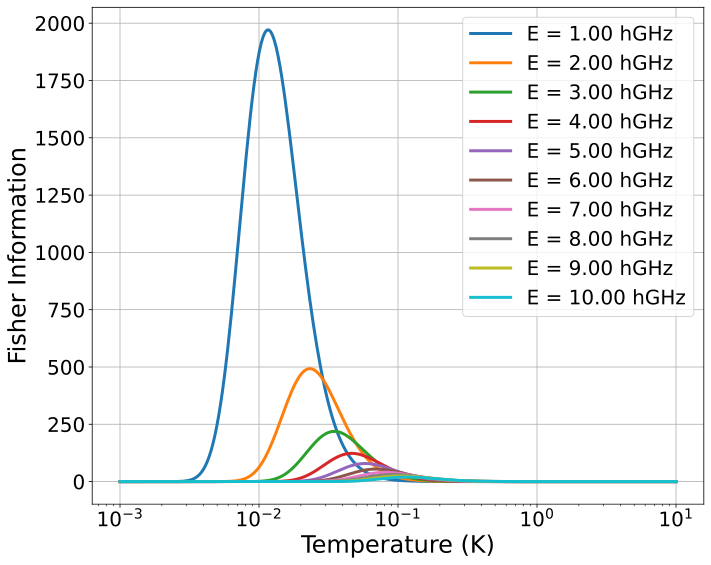

In [116]:
# let's get our arbitrary two level systems

# num_samples = 5
# rand = np.abs(np.random.randn(2,num_samples))
# E_list = np.zeros_like(rand)
# for n in range(num_samples):
#     E_list[:,n] = np.cumsum(rand[:,n])
#     E_list[:,n] = E_list[:,n]-E_list[0,n]
E_list = np.array([[0,1],[0,2],[0,3],[0,4],[0,5],[0,6],[0,7],[0,8],[0,9],[0,10]])  # Replace with your actual discrete spectrum of energies.
T_range = np.logspace(-3, 1.0, num=300)  # Inverse temperature range (replace with desired range).
beta_range = 1/(kB*T_range)  # Inverse temperature range (replace with desired range).
n_stop = 2  # Summing over all provided energy levels.
normalize = False
I_tot=0
I_arr = np.zeros((len(T_range),len(E_list)))
for index, E in enumerate(E_list):
    gibbs_mat = gibbs_distribution_matrix(E_list=E*h*giga, beta_range=beta_range, n_stop=n_stop)

    ln_gibbs_mat = np.log(gibbs_mat)

    d_ln_gibbs_mat = np.gradient(ln_gibbs_mat, T_range, axis=0)    # axis 0 is the rows, axis 1 is the columns

    I = np.sum(gibbs_mat*d_ln_gibbs_mat**2, axis=1)
    I_arr[:,index] = I
    I_tot += I

plt.figure(figsize=(10,8))
for n,E in enumerate(E_list):
    I = I_arr[:,n]
    if normalize:
        plt.semilogx(T_range, I/np.max(I),linewidth=3, label=f'E = {E[1]:.2f} hGHz')
    else:
        plt.semilogx(T_range, I,linewidth=3, label=f'E = {E[1]:.2f} hGHz')

#compare to a 10 level system
# E_list = np.array([0,1,2,3,4,5,6,7,8,9,10])  # Replace with your actual discrete spectrum of energies.
# gibbs_mat = gibbs_distribution_matrix(E_list=E_list, beta_range=beta_range, n_stop=len(E_list))
# ln_gibbs_mat = np.log(gibbs_mat)
# d_ln_gibbs_mat = np.gradient(ln_gibbs_mat, 1/beta_range, axis=0)    # axis 0 is the rows, axis 1 is the columns
# I = np.sum(gibbs_mat*d_ln_gibbs_mat**2, axis=1)
# plt.semilogx(1/beta_range, I,'r--',label=f'10 lvl Sys')
# plt.semilogx(1/beta_range, I_tot,'g*', label='sum TLS')

#compare to a 10 level system with levels spaced by cumulative sum of our 10 level system
# E_list = np.array([0,1,3,6,10,15,21,28,36,45,55])  # Replace with your actual discrete spectrum of energies.
# gibbs_mat = gibbs_distribution_matrix(E_list=E_list, beta_range=beta_range, n_stop=len(E_list))
# ln_gibbs_mat = np.log(gibbs_mat)
# d_ln_gibbs_mat = np.gradient(ln_gibbs_mat, 1/beta_range, axis=0)    # axis 0 is the rows, axis 1 is the columns
# I = np.sum(gibbs_mat*d_ln_gibbs_mat**2, axis=1)
# plt.semilogx(1/beta_range, I,color='xkcd:periwinkle', marker='s',linestyle='' ,label=f'cumsum 10 lvl Sys')

# #what about a 10 level system with levels with decreasing spacing?
# E_list = np.array([0,10,18,24,28,30])
# gibbs_mat = gibbs_distribution_matrix(E_list=E_list, beta_range=beta_range, n_stop=len(E_list))
# ln_gibbs_mat = np.log(gibbs_mat)
# d_ln_gibbs_mat = np.gradient(ln_gibbs_mat, 1/beta_range, axis=0)    # axis 0 is the rows, axis 1 is the columns
# I = np.sum(gibbs_mat*d_ln_gibbs_mat**2, axis=1)
# plt.semilogx(1/beta_range, I,color='xkcd:emerald', marker='<',linestyle='' ,label=f'decreasing spacing')


plt.xlabel('Temperature (K)', fontsize=24)
if normalize:
    plt.ylabel('Normalized Fisher Information',fontsize=24)
else:
    plt.ylabel('Fisher Information',fontsize=24)
plt.legend(fontsize=20)
plt.tick_params(axis='both', which='major', labelsize=20)
plt.tight_layout()
plt.grid()
plt.show()





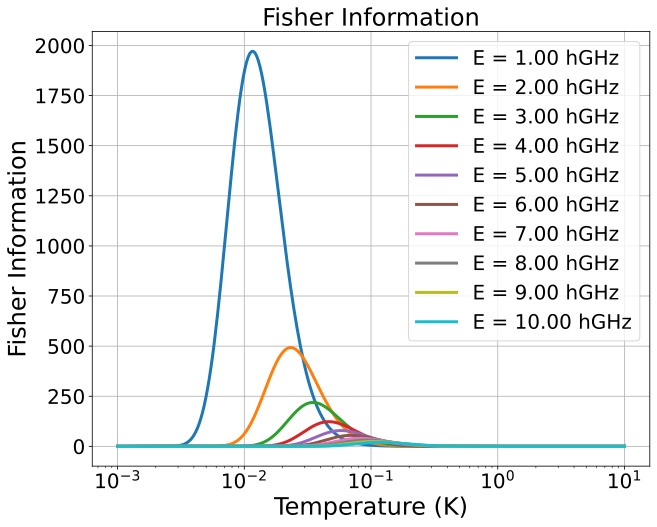

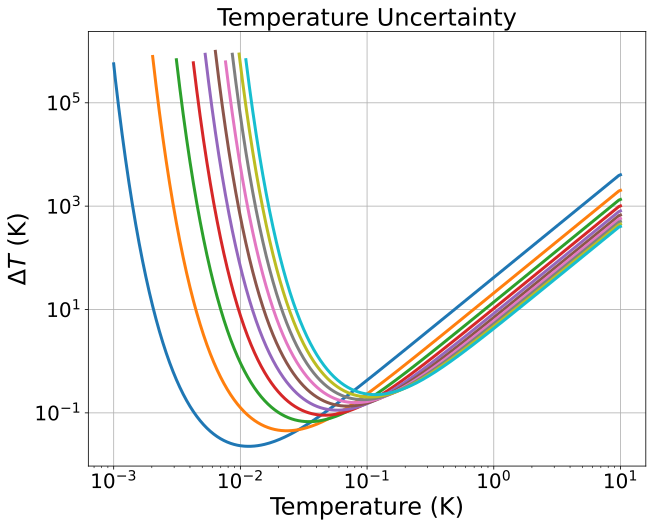

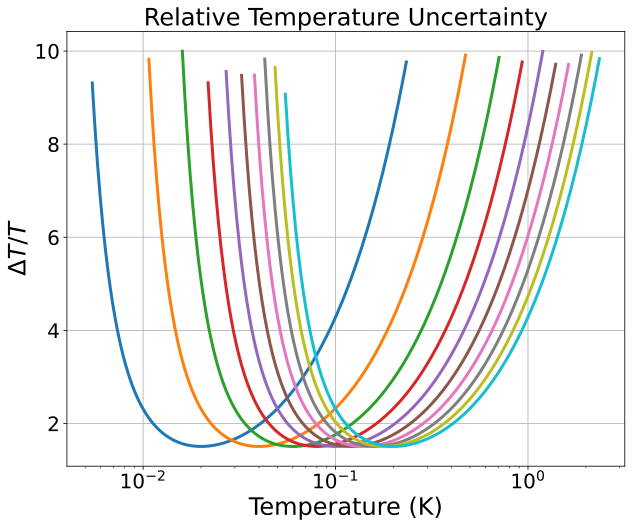

In [145]:
# Make some subfigs
# Create and condition the delta_T and rel_delta_T arrays
delta_T = 1/np.sqrt(I_arr)
delta_T[delta_T > 1e6] = np.nan

rel_delta_T = delta_T/T_range[:,np.newaxis]
rel_delta_T[rel_delta_T > 10] = np.nan


# Plot the first subplot
fig = plt.figure(figsize=(10,8))
for n, E in enumerate(E_list):
    plt.semilogx(T_range, I_arr[:,n],linewidth=3, label=f'E = {E[1]:.2f} hGHz')
    
plt.title('Fisher Information')
plt.ylabel('Fisher Information')
plt.xlabel('Temperature (K)')
plt.legend()
plt.grid()
plt.show()

fig = plt.figure(figsize=(10,8))
for n, E in enumerate(E_list):
    plt.loglog(T_range, delta_T[:,n],linewidth=3, label=f'E = {E[1]:.2f} hGHz')

plt.title('Temperature Uncertainty')
plt.ylabel('$\Delta T$ (K)')
plt.xlabel('Temperature (K)')
plt.grid()
plt.show()

fig = plt.figure(figsize=(10,8))
for n, E in enumerate(E_list):
    plt.semilogx(T_range, rel_delta_T[:,n],linewidth=3, label=f'E = {E[1]:.2f} hGHz')

plt.title('Relative Temperature Uncertainty')
plt.ylabel('$\Delta T/T$')
plt.xlabel('Temperature (K)')
plt.grid()
plt.show()



In [130]:
delta_T

array([[5.67060113e+05,            nan,            nan, ...,
                   nan,            nan,            nan],
       [2.82143097e+05,            nan,            nan, ...,
                   nan,            nan,            nan],
       [1.48145695e+05,            nan,            nan, ...,
                   nan,            nan,            nan],
       ...,
       [3.68073905e+03, 1.84038751e+03, 1.22694498e+03, ...,
        4.60186781e+02, 4.09077559e+02, 3.68192580e+02],
       [3.91463070e+03, 1.95733333e+03, 1.30490886e+03, ...,
        4.89423236e+02, 4.35065520e+02, 3.91581745e+02],
       [4.04092298e+03, 2.02047894e+03, 1.34700534e+03, ...,
        5.05206972e+02, 4.49094835e+02, 4.04207453e+02]])

 /var/folders/95/6hpqc6x16357gvp8z128f1380000gn/T/ipykernel_35429/4089525702.py: 9RuntimeWarning: invalid value encountered in add
 /Users/amarakov/opt/anaconda3/envs/scqubits/lib/python3.10/site-packages/numpy/lib/function_base.py: 1223RuntimeWarning: invalid value encountered in subtract
 /Users/amarakov/opt/anaconda3/envs/scqubits/lib/python3.10/site-packages/numpy/lib/function_base.py: 1239RuntimeWarning: divide by zero encountered in log
 /var/folders/95/6hpqc6x16357gvp8z128f1380000gn/T/ipykernel_35429/4089525702.py: 9RuntimeWarning: invalid value encountered in add
 /Users/amarakov/opt/anaconda3/envs/scqubits/lib/python3.10/site-packages/numpy/lib/function_base.py: 1223RuntimeWarning: invalid value encountered in subtract
 /Users/amarakov/opt/anaconda3/envs/scqubits/lib/python3.10/site-packages/numpy/lib/function_base.py: 1239RuntimeWarning: divide by zero encountered in log
 /var/folders/95/6hpqc6x16357gvp8z128f1380000gn/T/ipykernel_35429/4089525702.py: 9RuntimeWarning: invalid 

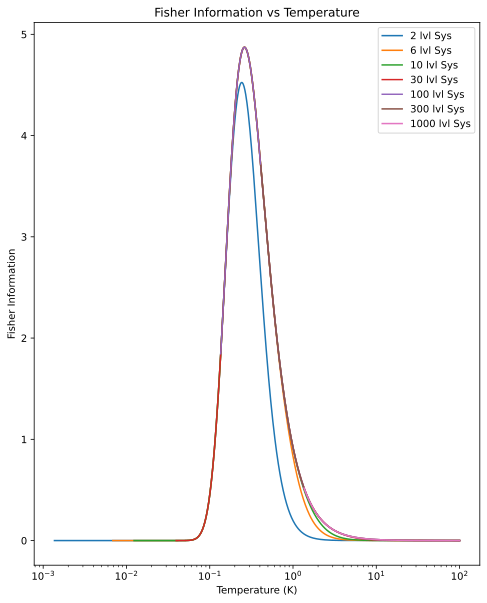

In [98]:
# What happens if we just keep adding levels?

E_list = np.linspace(0,1000,1000)
n_stop_list = [2,6,10,30,100,300,1000]
beta_range = np.logspace(-2, 3, num=1000)  # Inverse temperature range (replace with desired range).
plt.figure(figsize=(8,10))
for n_stop in n_stop_list:
    gibbs_mat = gibbs_distribution_matrix(E_list=E_list, beta_range=beta_range, n_stop=n_stop)
    ln_gibbs_mat = np.log(gibbs_mat)
    d_ln_gibbs_mat = np.gradient(ln_gibbs_mat, 1/beta_range, axis=0)    # axis 0 is the rows, axis 1 is the columns
    I = np.sum(gibbs_mat*d_ln_gibbs_mat**2, axis=1)
    plt.semilogx(1/beta_range, I,label=f'{n_stop} lvl Sys')

plt.xlabel('Temperature (K)')
plt.ylabel('Fisher Information')
plt.title('Fisher Information vs Temperature')
plt.legend()
plt.show()


 /var/folders/95/6hpqc6x16357gvp8z128f1380000gn/T/ipykernel_35429/2412510108.py: 29RuntimeWarning: invalid value encountered in add
 /Users/amarakov/opt/anaconda3/envs/scqubits/lib/python3.10/site-packages/numpy/lib/function_base.py: 1223RuntimeWarning: invalid value encountered in subtract
 /Users/amarakov/opt/anaconda3/envs/scqubits/lib/python3.10/site-packages/numpy/lib/function_base.py: 1232

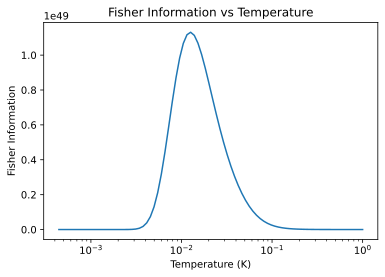

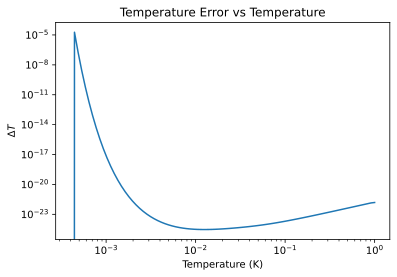

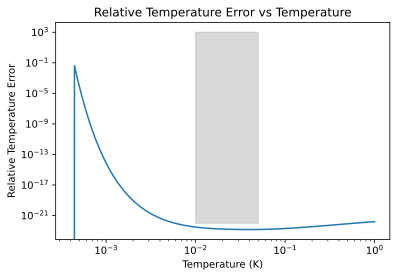

[2.66597893e+03 2.42914071e+03 2.21334254e+03 2.01671529e+03
 1.83755586e+03 1.67431247e+03 1.52557116e+03 1.39004362e+03
 1.26655598e+03 1.15403864e+03 1.05151703e+03 9.58103151e+02
 8.72987908e+02 7.95434068e+02 7.24769898e+02 6.60383338e+02
 6.01716702e+02 5.48261849e+02 4.99555777e+02 4.55176619e+02
 4.14739982e+02 3.77895625e+02 3.44324420e+02 3.13735587e+02
 2.85864182e+02 2.60468796e+02 2.37329466e+02 2.16245771e+02
 1.97035092e+02 1.79531038e+02 1.63581995e+02 1.49049822e+02
 1.35808646e+02 1.23743780e+02 1.12750724e+02 1.02734260e+02
 9.36076319e+01 8.52917878e+01 7.77147005e+01 7.08107407e+01
 6.45201096e+01 5.87883209e+01 5.35657285e+01 4.88070968e+01
 4.44712089e+01 4.05205092e+01 3.69207789e+01 3.36408386e+01
 3.06522793e+01 2.79292152e+01 2.54480607e+01 2.31873252e+01
 2.11274271e+01 1.92505247e+01 1.75403611e+01 1.59821238e+01
 1.45623160e+01 1.32686400e+01 1.20898906e+01 1.10158580e+01
 1.00372395e+01 9.14555884e+00 8.33309260e+00 7.59280362e+00
 6.91827987e+00 6.303678

In [9]:
import scqubits as scq
import scipy.constants as const
import numpy as np

h = const.h
kB = const.Boltzmann
giga = const.giga
# define the qubit
qubit = scq.Transmon(
    EJ=40.0,
    EC=0.1,
    ng=0.0,
    ncut=20,
)

f = qubit.eigenvals()

f=f-f[0]

E_list = h*f*giga
f_ho = np.arange(20)+1
E_ho = h*f_ho*giga #harmonic oscillator energies
T_range = np.logspace(-4, 0, num=100)  # temperature range (replace with desired range).

beta_range = 1/(kB*T_range)

gibbs_mat = gibbs_distribution_matrix(E_list=E_ho, beta_range=beta_range, n_stop=len(E_list))

ln_gibbs_mat = np.log(gibbs_mat)

d_ln_gibbs_mat = np.gradient(ln_gibbs_mat, 1/beta_range, axis=0)    # axis 0 is the rows, axis 1 is the columns

I = np.sum(gibbs_mat*d_ln_gibbs_mat**2, axis=1)

# highlight plot region of operation
T_op = np.logspace(-2,-1.3, num=100) #1 mK to 100 mK
y_op1 = 1e-22
y_op2 = 1e3

plt.figure()
plt.semilogx(T_range, I)
plt.xlabel('Temperature (K)')
plt.ylabel('Fisher Information')
plt.title('Fisher Information vs Temperature')
plt.show()


delta_T = np.sqrt(1/I)

#plot standard deviation
plt.figure()
plt.loglog(T_range, delta_T)
plt.xlabel('Temperature (K)')
plt.ylabel('$\Delta T$')
plt.title('Temperature Error vs Temperature')
plt.show()

#plot relative T error
plt.figure()
plt.loglog(T_range, delta_T/T_range)
plt.fill_between(T_op, y_op1,y_op2, color='grey', alpha=0.3)
plt.xlabel('Temperature (K)')
plt.ylabel('Relative Temperature Error')
plt.title('Relative Temperature Error vs Temperature')
plt.show()

print(E_list[1]*beta_range)

In [10]:
np.log10(0.05)

-1.3010299956639813

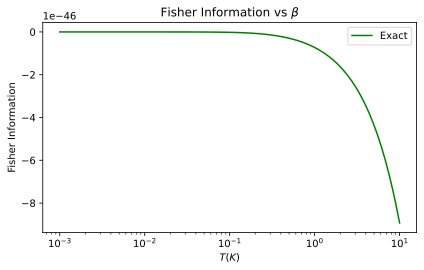

In [37]:
# these results don't match my earlier stuff, so let's try to figure out why

def ho_gibbs(E,beta,n):
    # beta is 1/kT
    # n is the energy level
    # we let E = 1 without loss of generality
    # Partition function is 1/(1-exp(-beta)) for Geomertric series
    return np.exp(-E*beta*n)*(1-np.exp(-beta*E))

def integrand_exact(E,beta,n_stop):
    denom = (np.exp(beta*E)-1)
    denom = denom.reshape(-1,1)
    return -E**2*np.exp(-np.outer(E*beta,np.arange(n_stop)))/denom



n_stop = 10
beta_range = 1/(kB*np.logspace(-3,1,100))
ho_gibbs_mat = np.zeros((len(beta_range), n_stop))
gibbs_mat = np.zeros((len(beta_range), n_stop))
E_list = (np.arange(10)+1)*h*giga
for n in range(n_stop):
    ho_gibbs_mat[:,n] = ho_gibbs(E_list[0],beta_range,n)
    
gibbs_mat = gibbs_distribution_matrix(E_list=E_list, beta_range=beta_range, n_stop=len(E_list))
    

#harmonic oscillator version
ln_ho_gibbs_mat = np.log(ho_gibbs_mat)
d_ln_ho_gibbs_mat = np.gradient(ln_ho_gibbs_mat, 1/beta_range, axis=0)    # axis 0 is the rows, axis 1 is the columns
d2_ln_ho_gibbs_mat = np.gradient(d_ln_ho_gibbs_mat, 1/beta_range, axis=0)    # axis 0 is the rows, axis 1 is the columns

ho_I = np.sum(ho_gibbs_mat*d_ln_ho_gibbs_mat**2, axis=1)
ho_I1 = np.sum(-ho_gibbs_mat*d2_ln_ho_gibbs_mat, axis=1)

#general version
ln_gibbs_mat = np.log(gibbs_mat)
d_ln_gibbs_mat = np.gradient(ln_gibbs_mat, 1/beta_range, axis=0)    # axis 0 is the rows, axis 1 is the columns
d2_ln_gibbs_mat = np.gradient(d_ln_gibbs_mat, 1/beta_range, axis=0)    # axis 0 is the rows, axis 1 is the columns

I = np.sum(gibbs_mat*d_ln_gibbs_mat**2, axis=1)
I1 = np.sum(-gibbs_mat*d2_ln_gibbs_mat, axis=1)

I_exact = np.sum(integrand_exact(E_list[0],beta_range,n_stop), axis=1)

plt.figure()
# plt.semilogx(1/(kB*beta_range), I, 'r*', label='Using $\\frac{\partial}{\partial \\beta}^2$')
# plt.semilogx(1/(kB*beta_range), I1, 'r+', label= 'Using $\\frac{\partial ^2}{\partial \\beta ^2}$')
# plt.semilogx(1/(kB*beta_range), ho_I, 'b*', label='Using $\\frac{\partial}{\partial \\beta}^2$ (HO)')
# plt.semilogx(1/(kB*beta_range), ho_I1, 'b+', label= 'Using $\\frac{\partial ^2}{\partial \\beta ^2}$ (HO)')
plt.semilogx(1/(kB*beta_range), I_exact, 'g-', label='Exact')
plt.xlabel('$T (K)$')
plt.ylabel('Fisher Information')
plt.title('Fisher Information vs $\\beta$')
plt.legend()
plt.tight_layout()
plt.show()



array([6.62607015e-25, 1.32521403e-24, 1.98782105e-24, 2.65042806e-24,
       3.31303508e-24, 3.97564209e-24, 4.63824911e-24, 5.30085612e-24,
       5.96346314e-24, 6.62607015e-24])

In [140]:
np.shape(gibbs_distribution_matrix(E_list=np.arange(n_stop), beta_range=beta_range, n_stop=n_stop))

(100, 10)